Возьмём функцию:

$$
y(x) = a x^2 + b \sin(c x)
$$

Где:
- $a, b, c$ — константы,
- $x$ — значения из заданного интервала.

In [ ]:
# Создание набора данных
import numpy as np
import torch

# Задаем параметры функции
a = 1.0
b = 2.0
c = 3.0

# Генерируем значения x
x = np.linspace(-10, 10, 1000)

# Вычисляем y(x)
y = a * x**2 + b * np.sin(c * x)

# Преобразуем в тензоры PyTorch
x_tensor = torch.from_numpy(x).float().unsqueeze(1)
y_tensor = torch.from_numpy(y).float().unsqueeze(1)


In [3]:
from torch.utils.data import Dataset, DataLoader

class FunctionDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.y[idx]

# Создаем датасет и загрузчик данных
dataset = FunctionDataset(x_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [4]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_dim),
        )

    def forward(self, z):
        output = self.model(z)
        return output


In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, True),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output


In [9]:
import torch.optim as optim

# Параметры
latent_dim = 10
lr = 0.0002
n_epochs = 300
device = 'cuda'

# Инициализация моделей
generator = Generator(latent_dim, 1).to(device)
discriminator = Discriminator(1).to(device)

# Оптимизаторы
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Функция потерь
adversarial_loss = nn.BCELoss()

# Обучение
for epoch in range(n_epochs):
    for i, real_data in enumerate(data_loader):
        batch_size = real_data.size(0)
        real_data = real_data.to(device)

        # Метки для реальных и фейковых данных
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # ---------------------
        #  Обновление генератора
        # ---------------------
        optimizer_G.zero_grad()

        # Генерация шума
        z = torch.randn(batch_size, latent_dim).to(device)

        # Генерация данных
        generated_data = generator(z)

        # Вычисление потерь генератора
        g_loss = adversarial_loss(discriminator(generated_data), valid)

        # Обновление генератора
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Обновление дискриминатора
        # ---------------------
        optimizer_D.zero_grad()

        # Потери на реальных данных
        real_loss = adversarial_loss(discriminator(real_data), valid)

        # Потери на сгенерированных данных
        fake_loss = adversarial_loss(discriminator(generated_data.detach()), fake)

        # Суммарные потери дискриминатора
        d_loss = (real_loss + fake_loss) / 2

        # Обновление дискриминатора
        d_loss.backward()
        optimizer_D.step()

    # Выводим прогресс
    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")


[Epoch 1/300] [D loss: 0.3843] [G loss: 0.7162]
[Epoch 2/300] [D loss: 0.3308] [G loss: 0.9857]
[Epoch 3/300] [D loss: 0.3030] [G loss: 1.3360]
[Epoch 4/300] [D loss: 0.2418] [G loss: 1.4211]
[Epoch 5/300] [D loss: 0.3613] [G loss: 1.4904]
[Epoch 6/300] [D loss: 0.4576] [G loss: 1.3250]
[Epoch 7/300] [D loss: 0.4583] [G loss: 1.3916]
[Epoch 8/300] [D loss: 0.5527] [G loss: 1.2907]
[Epoch 9/300] [D loss: 0.4967] [G loss: 1.1676]
[Epoch 10/300] [D loss: 0.5264] [G loss: 1.0657]
[Epoch 11/300] [D loss: 0.4726] [G loss: 1.1291]
[Epoch 12/300] [D loss: 0.5240] [G loss: 1.1826]
[Epoch 13/300] [D loss: 0.5645] [G loss: 0.9832]
[Epoch 14/300] [D loss: 0.5609] [G loss: 0.8660]
[Epoch 15/300] [D loss: 0.5770] [G loss: 1.0504]
[Epoch 16/300] [D loss: 0.5215] [G loss: 1.1429]
[Epoch 17/300] [D loss: 0.5087] [G loss: 0.9574]
[Epoch 18/300] [D loss: 0.5126] [G loss: 1.0423]
[Epoch 19/300] [D loss: 0.5103] [G loss: 0.8384]
[Epoch 20/300] [D loss: 0.5532] [G loss: 0.8879]
[Epoch 21/300] [D loss: 0.522

- D loss (потери дискриминатора): Это значение показывает, насколько хорошо дискриминатор отличает реальные данные от сгенерированных. В начале обучения потери дискриминатора ниже, что указывает на успешное разделение реальных и сгенерированных данных. По мере обучения D loss растет и колеблется, так как генератор становится лучше в «обмане» дискриминатора, что усложняет его задачу.
- G loss (потери генератора): Это значение показывает, насколько генератор успешно обманывает дискриминатор. Если потери генератора уменьшаются, это значит, что он генерирует данные, более похожие на реальные. На более поздних эпохах потери генератора колеблются, показывая, что он пытается адаптироваться к улучшениям дискриминатора.

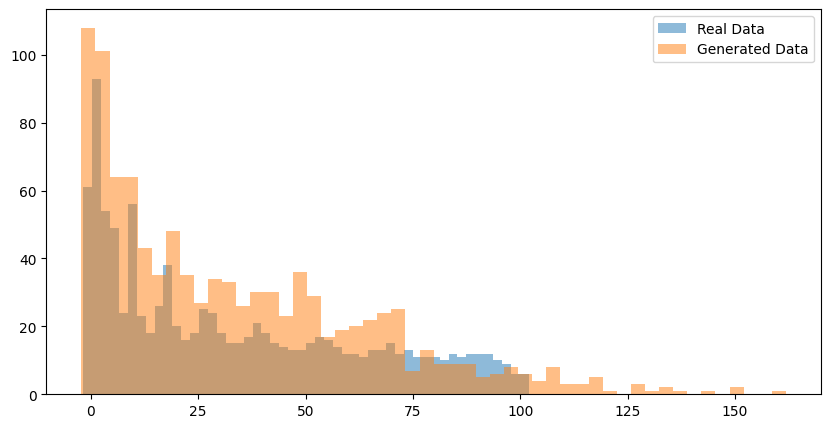

In [10]:
import matplotlib.pyplot as plt

# Генерируем данные
z = torch.randn(1000, latent_dim).to(device)
generated_data = generator(z).cpu().detach().numpy()

# Преобразуем реальные данные в numpy
real_data_np = y_tensor.numpy()

# Визуализация
plt.figure(figsize=(10, 5))
plt.hist(real_data_np, bins=50, alpha=0.5, label="Real Data")
plt.hist(generated_data, bins=50, alpha=0.5, label="Generated Data")
plt.legend()
plt.show()


Ось X на графике гистограммы показывает значения функции y(x) из набора данных, построенных по функции. В данном случае, это распределение значений, которые генератор обучается воспроизводить.

Ось Y показывает частоту (количество значений), которые попадают в соответствующие диапазоны (корзины) на оси X.

На графике видно, что гистограммы для реальных данных (голубой цвет) и сгенерированных данных (оранжевый цвет) немного отличаются, хотя генератор пытается подогнать сгенерированные данные к распределению реальных данных.